# ノートブックの概要
- EDAのためのノートブック。以下のことを行っている
  - データの読み込み
  - 時系列データの可視化、短期的な変動の解析
  - 時期の区切りを検討
  - 引っ越し数y==0となっている部分の確認
  - 数値変換を試す

# ライブラリのインポート

In [1]:
import polars as pl
import polars.selectors as cs
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(100)
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

from datetime import date
import matplotlib.dates as mdates

import jpholiday

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

c:\Users\NDY02\venvs\venv_apple_hikkosi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# データ読み込んでみる

In [2]:
train = pl.read_csv("../data/input/train.csv")
test = pl.read_csv("../data/input/test.csv")
sample_submit = pl.read_csv("../data/input/sample_submit.csv", has_header=False)

print("train\n", train)
print("test\n", test)
print("sample_submit\n", sample_submit)

train
 shape: (2_101, 6)
┌────────────┬─────┬────────┬───────┬──────────┬──────────┐
│ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm │
│ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      │
│ str        ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      │
╞════════════╪═════╪════════╪═══════╪══════════╪══════════╡
│ 2010-07-01 ┆ 17  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-02 ┆ 18  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-03 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-04 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-05 ┆ 14  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ …          ┆ …   ┆ …      ┆ …     ┆ …        ┆ …        │
│ 2016-03-27 ┆ 94  ┆ 1      ┆ 0     ┆ 5        ┆ 4        │
│ 2016-03-28 ┆ 86  ┆ 1      ┆ 0     ┆ 4        ┆ 4        │
│ 2016-03-29 ┆ 98  ┆ 1      ┆ 0     ┆ 4        ┆ 4        │
│ 2016-03-30 ┆ 99  ┆ 1      ┆ 0     ┆ 5        ┆ 4        │
│ 2016-03-31 ┆ 105 ┆ 1      ┆ 0     ┆ 5        ┆ 4        │
└────────────┴─

データの読み方について  

例えば  
│datetime   | y   | client | close | price_am | price_pm |
| ---- | ---- | ---- | ---- | ---- | ---- |
│2016-03-28 | 86  | 1      | 0     | 4        | 4        │  

といったとき。  
これは、  
日時「2016-03-28」について、この日は  
合計引っ越し数は「86件」  
法人が絡む特殊な引越し日フラグは「あり」  
この日の午前料金区分は「4」  
この日の午後料金区分は「4」  
といった意味っぽい  

In [3]:
# IDとして使用されているdatetimeカラムを文字列型と日付型に分離
# カラムの役割を分散することでコードエラーを発生しにくくする
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype=pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype=pl.Date))

print(train.head())

shape: (5, 7)
┌────────────┬────────────┬─────┬────────┬───────┬──────────┬──────────┐
│ id         ┆ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm │
│ ---        ┆ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      │
│ str        ┆ date       ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      │
╞════════════╪════════════╪═════╪════════╪═══════╪══════════╪══════════╡
│ 2010-07-01 ┆ 2010-07-01 ┆ 17  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-02 ┆ 2010-07-02 ┆ 18  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-03 ┆ 2010-07-03 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-04 ┆ 2010-07-04 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
│ 2010-07-05 ┆ 2010-07-05 ┆ 14  ┆ 0      ┆ 0     ┆ -1       ┆ -1       │
└────────────┴────────────┴─────┴────────┴───────┴──────────┴──────────┘


# 時系列データを可視化

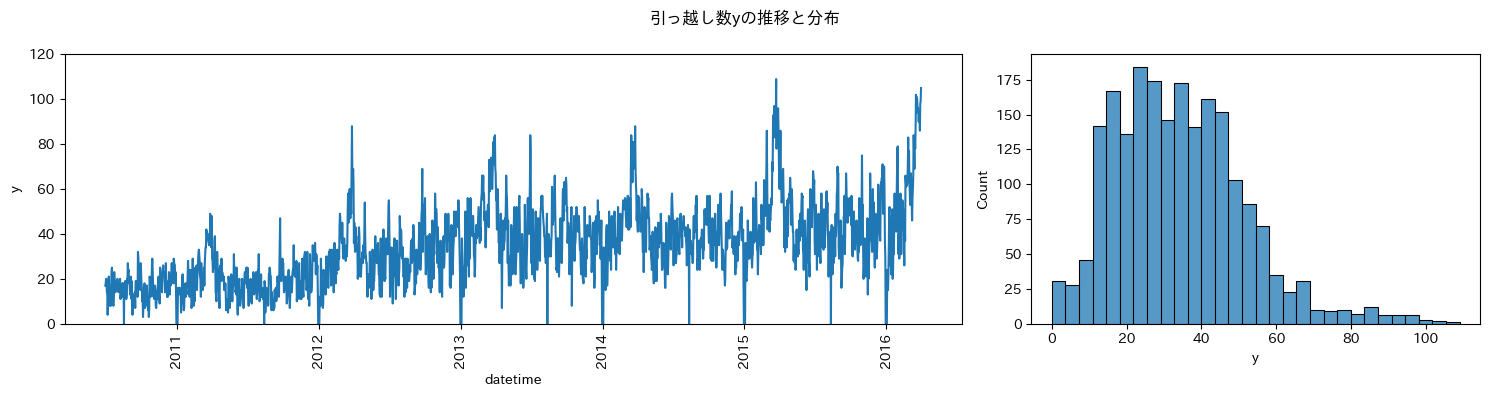

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time = sns.lineplot(data = train, x="datetime", y="y", ax=axes[0])
g_hist = sns.histplot(data = train, x="y", ax=axes[1])

plt.setp(g_time.get_xticklabels(), rotation=90)
plt.setp(g_time, ylim=(0, 120))
plt.suptitle("引っ越し数yの推移と分布")
plt.tight_layout()

plt.show()

グラフについてのコメント  
- 引っ越し数yは、年を経るごとに増加傾向
- 繁忙期(3~4月)は他の時期と比べて明確に異なりそう(大きなピークとなっている)
- 引っ越し数yが0の日がある
- yの分布は非対称 → 数値変換すると良いかも？

ひとり言  
- 引越し数が増加傾向であるというビジネスとして喜ばしいことが、このコンペを難しくしています。
- 何故なら、機械学習モデルは訓練データとテストデータの目的変数の確率分布が等しいことを前提としているので、確率分布が変化すると予測精度が悪化するからです。
- 例えば、2011年の生データで2012年の引越し数を予測すると、常に小さな予測値が出る人手不足の1年になります。
- 予測精度を高めるために、日時tの影響をキャンセルする必要があります。

## 解析(良く分かっていない)

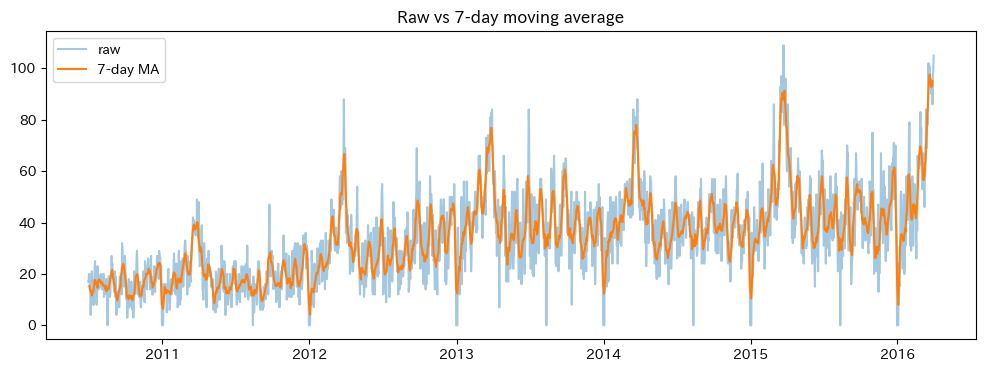

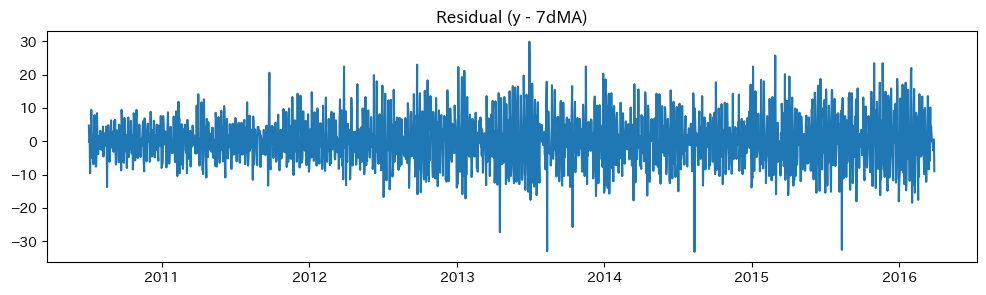

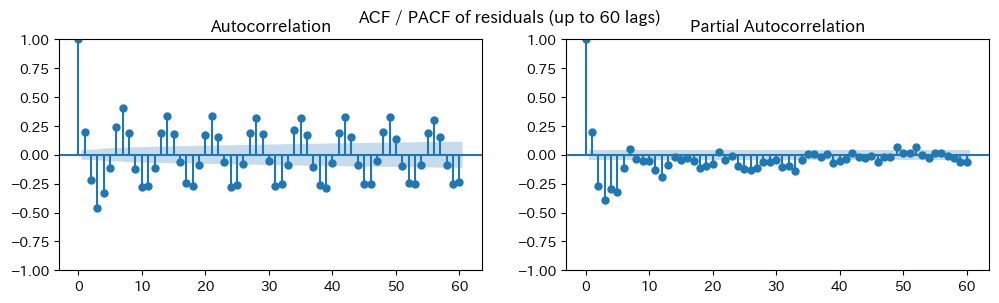

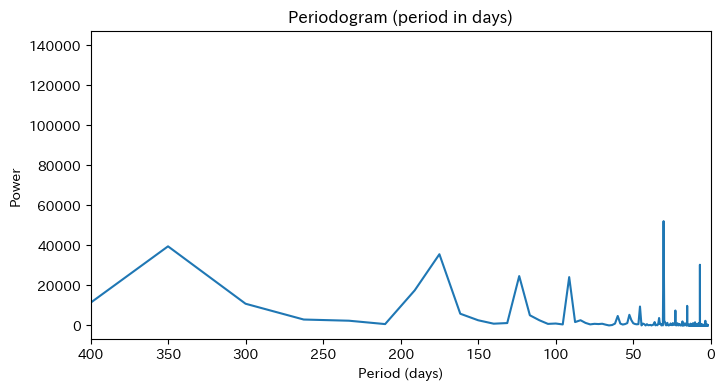

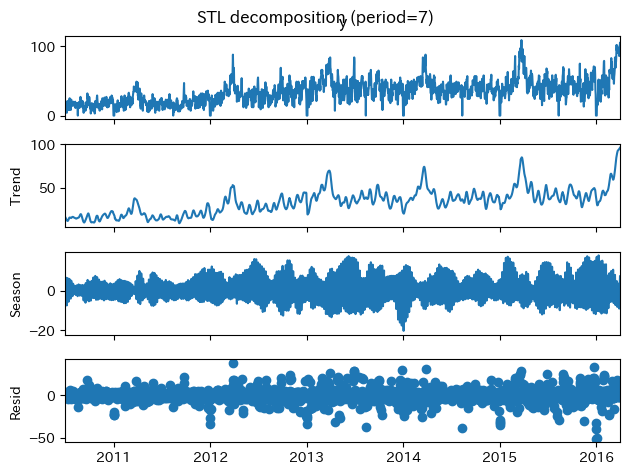

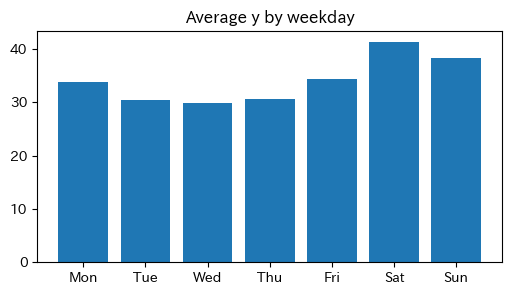

Holiday mean y: 34.791666666666664 Non-holiday mean y: 34.06334164588529


In [ ]:
# 平滑化 / ACF / FFT / STL / 曜日集計
# 正直、良くわかってない。あまり上手く出来ていない気がする。
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from scipy.signal import periodogram
import jpholiday

# polars -> pandas
df = train.to_pandas()
df['id'] = pd.to_datetime(df['id'])
df = df.set_index('id').sort_index()

# 1) 平滑化（移動平均）と残差
df['y_roll7'] = df['y'].rolling(7, center=True).mean()
df['y_resid'] = df['y'] - df['y_roll7']

plt.figure(figsize=(12,4))
plt.plot(df.index, df['y'], alpha=0.4, label='raw')
plt.plot(df.index, df['y_roll7'], color='C1', label='7-day MA')
plt.legend(); plt.title('Raw vs 7-day moving average'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(df.index, df['y_resid']); plt.title('Residual (y - 7dMA)'); plt.show()

# 2) ACF / PACF（残差で確認すると短期周期が見やすい）
fig, axes = plt.subplots(1,2,figsize=(12,3))
plot_acf(df['y_resid'].dropna(), lags=60, ax=axes[0])
plot_pacf(df['y_resid'].dropna(), lags=60, ax=axes[1])
plt.suptitle('ACF / PACF of residuals (up to 60 lags)'); plt.show()

# 3) 周波数スペクトル（FFT / periodogram）
y = df['y'].fillna(df['y'].mean()).values - df['y'].mean()
f, Pxx = periodogram(y, fs=1)  # fs=1 day^-1
mask = f > 0
periods = 1 / f[mask]
plt.figure(figsize=(8,4))
plt.plot(periods, Pxx[mask])
plt.xlim(0, 400)  # 必要に応じて変更（表示する周期の上限）
plt.xlabel('Period (days)'); plt.ylabel('Power'); plt.title('Periodogram (period in days)')
plt.gca().invert_xaxis()  # 短周期を右から左に見やすく
plt.show()

# 4) STL 分解（例: 7日周期の季節性を想定）
stl = STL(df['y'], period=7, robust=True)
res = stl.fit()
res.plot(); plt.suptitle('STL decomposition (period=7)'); plt.show()

# 5) 曜日別集計（週次パターンの把握）
df['weekday'] = df.index.weekday  # 0=Mon..6=Sun
weekday_mean = df.groupby('weekday')['y'].mean()
plt.figure(figsize=(6,3))
plt.bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], weekday_mean.values)
plt.title('Average y by weekday'); plt.show()

# 6) 祝日影響（jpholiday を利用）
df['is_holiday'] = [jpholiday.is_holiday(d.date()) for d in df.index]
print('Holiday mean y:', df.loc[df['is_holiday'],'y'].mean(), 'Non-holiday mean y:', df.loc[~df['is_holiday'],'y'].mean())

# 区切り。年ごと？年度ごと？

In [ ]:
# 年ごとで分けるか？年度ごとで分けるか？

train = (
    train
    .with_columns([
        pl.col("datetime").dt.year().alias("year"),
        pl.when(pl.col("datetime").dt.month() <= 3).then(pl.col("datetime").dt.year() - 1)
        .otherwise(pl.col("datetime").dt.year())
        .alias("fy")
    ])
)
print(train.head(5))

shape: (5, 9)
┌────────────┬────────────┬─────┬────────┬───────┬──────────┬──────────┬──────┬──────┐
│ id         ┆ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm ┆ year ┆ fy   │
│ ---        ┆ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      ┆ ---  ┆ ---  │
│ str        ┆ date       ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      ┆ i32  ┆ i32  │
╞════════════╪════════════╪═════╪════════╪═══════╪══════════╪══════════╪══════╪══════╡
│ 2010-07-01 ┆ 2010-07-01 ┆ 17  ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 │
│ 2010-07-02 ┆ 2010-07-02 ┆ 18  ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 │
│ 2010-07-03 ┆ 2010-07-03 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 │
│ 2010-07-04 ┆ 2010-07-04 ┆ 20  ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 │
│ 2010-07-05 ┆ 2010-07-05 ┆ 14  ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 │
└────────────┴────────────┴─────┴────────┴───────┴──────────┴──────────┴──────┴──────┘


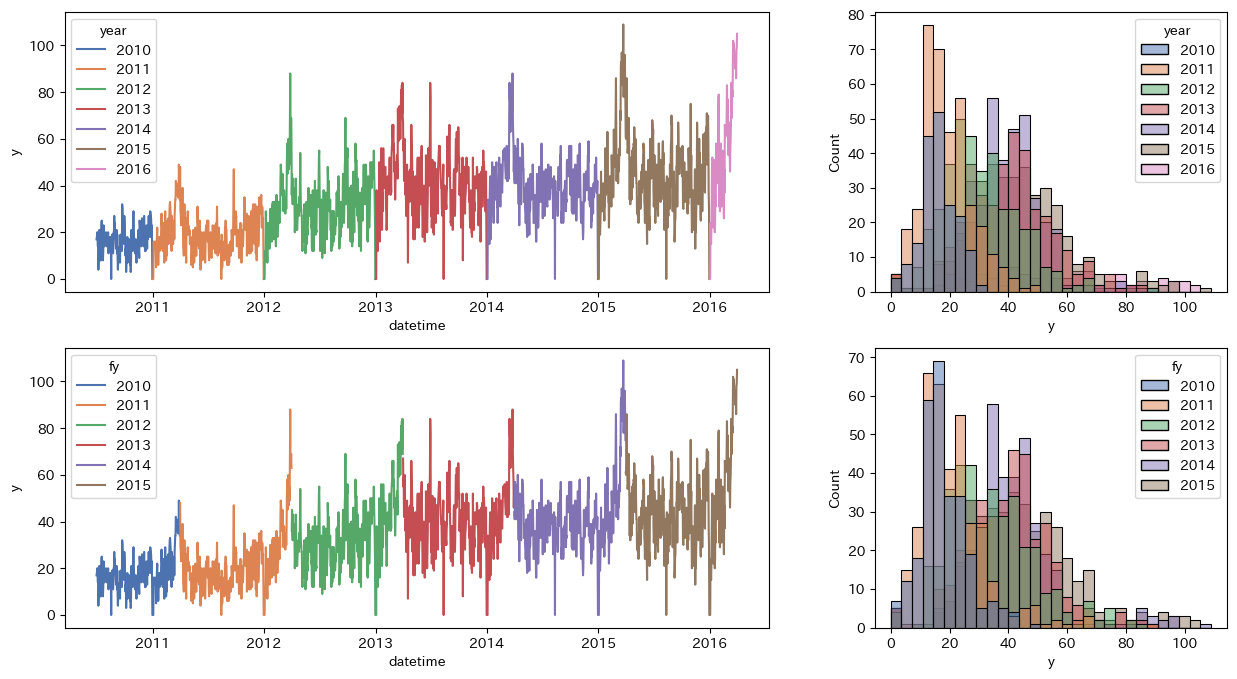

In [ ]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    height_ratios=[1, 1], width_ratios=[2, 1],
    figsize=(15, 8)
)

g_time_year = sns.lineplot(data = train, x="datetime", y="y", hue="year", palette="deep", ax=axes[0, 0])
g_hist_year = sns.histplot(data = train, x="y", hue="year", palette="deep", ax=axes[0, 1])

g_time_fy = sns.lineplot(data = train, x="datetime", y="y", hue="fy", palette="deep", ax=axes[1, 0])
g_hist_fy = sns.histplot(data = train, x="y", hue="fy", palette="deep", ax=axes[1, 1])

plt.show()

グラフへのコメント  
- 年度で分けると、繁忙期(3~4月)のピークが分割されてしまい分析が難しくなってしまう。そのため、年ごとで分けるのが適切かと

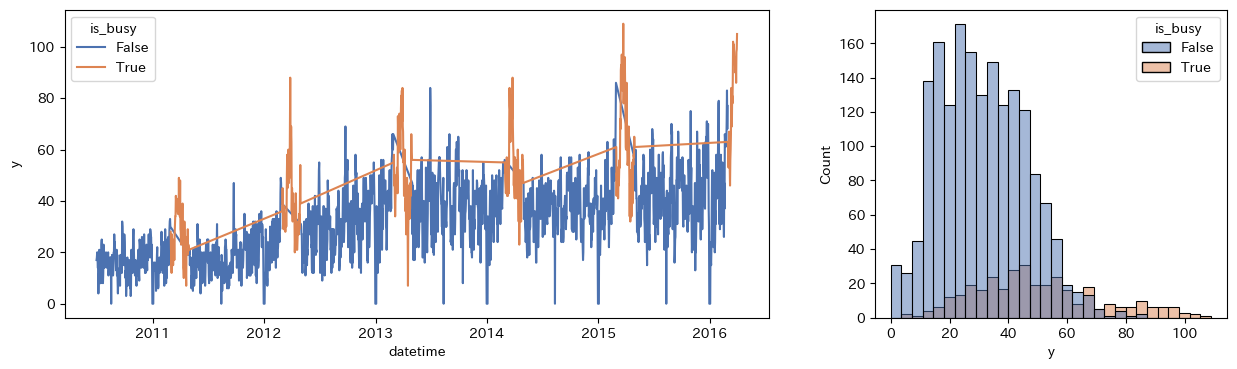

In [ ]:
# 繁忙期を抜き出して見てみる

train = train.with_columns(
    (
        ((pl.col("datetime").dt.month() == 3) | (pl.col("datetime").dt.month() == 4))
    ).alias("is_busy")
)

fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time = sns.lineplot(data = train, x="datetime", y="y", hue="is_busy", palette="deep", ax=axes[0])
g_hist = sns.histplot(data = train, x="y", hue="is_busy", palette="deep", ax=axes[1])

# y==0の部分って？

In [ ]:
# y==0、close==1のデータを抽出。引っ越し件数が0件または休業日の場合
with pl.Config(tbl_rows=-1):
    print(
        train.filter(
            (pl.col("y") == 0) | (pl.col("close") == 1)
        )
    )

shape: (29, 10)
┌────────────┬────────────┬─────┬────────┬───────┬──────────┬──────────┬──────┬──────┬─────────┐
│ id         ┆ datetime   ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm ┆ year ┆ fy   ┆ is_busy │
│ ---        ┆ ---        ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      ┆ ---  ┆ ---  ┆ ---     │
│ str        ┆ date       ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      ┆ i32  ┆ i32  ┆ bool    │
╞════════════╪════════════╪═════╪════════╪═══════╪══════════╪══════════╪══════╪══════╪═════════╡
│ 2010-08-18 ┆ 2010-08-18 ┆ 0   ┆ 0      ┆ 0     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 ┆ false   │
│ 2010-12-31 ┆ 2010-12-31 ┆ 0   ┆ 0      ┆ 1     ┆ -1       ┆ -1       ┆ 2010 ┆ 2010 ┆ false   │
│ 2011-01-01 ┆ 2011-01-01 ┆ 0   ┆ 0      ┆ 1     ┆ -1       ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-01-02 ┆ 2011-01-02 ┆ 0   ┆ 0      ┆ 1     ┆ -1       ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-01-03 ┆ 2011-01-03 ┆ 0   ┆ 0      ┆ 1     ┆ -1       ┆ -1       ┆ 2011 ┆ 2010 ┆ false   │
│ 2011-08-14 ┆

y=0の部分についてのコメント  
- これは…お盆のときと、年末年始(12/31~1/3)のときに全く引っ越しがないっぽいな。毎年そうみたい
- y=0の部分は機械学習に任せるのではなく、ルールベースで決めてしまったほうが良いかも
- よく見ると、休業日(close==1)とほぼ一致している。年末年始は毎年休業日かつ引っ越し0
  - ただし、お盆は休業日じゃないけど引っ越し0

休業日の場合についてのコメント  
- 休業日(close==1)の場合は全てy==0。これはもうルールベースで書いてしまった方が良いかな
- お盆は…どうなんだろう。今後お盆が休業日じゃなくなる日ってあるんだろうか？
  - お盆は毎年日にちが異なるので…日時でルールを決めるの難しそう
  - うーん、close==1を使ってルールを決めるのにとどめたほうがいいかな？
  - 2010年だけ例外的にお盆も営業していた？

In [ ]:
# 休業日の場合は引っ越し数0。これはルールベースで予測することとする。そのため学習からは除外

# trainからpl.col("y"==0)である部分を除外する
# 2010-08-18と2011-08-14はお盆であるものの休業日に設定されていなかったが、
# 以降の年では休業日に設定されたみたいなので学習からは取り除いておく
train = train.filter(
    (pl.col("close") != 1)
    & (pl.col("id") != "2010-08-18")
    & (pl.col("id") != "2011-08-14")
)

# test_close: testデータの中で休業日の部分(pl.col("close"==1))を抜き出し、
# その日は引っ越し数0(pl.col("y"==0))であるとしたdataframe
# 元のtestからはその部分は取り除いておく
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

In [ ]:
# y==0、close==1のデータを抽出。引っ越し件数が0件または休業日の場合
with pl.Config(tbl_rows=-1):
    print(
        train.filter(
            (pl.col("y") == 0) | (pl.col("close") == 1)
        )
    )

shape: (0, 10)
┌─────┬──────────┬─────┬────────┬───────┬──────────┬──────────┬──────┬─────┬─────────┐
│ id  ┆ datetime ┆ y   ┆ client ┆ close ┆ price_am ┆ price_pm ┆ year ┆ fy  ┆ is_busy │
│ --- ┆ ---      ┆ --- ┆ ---    ┆ ---   ┆ ---      ┆ ---      ┆ ---  ┆ --- ┆ ---     │
│ str ┆ date     ┆ i64 ┆ i64    ┆ i64   ┆ i64      ┆ i64      ┆ i32  ┆ i32 ┆ bool    │
╞═════╪══════════╪═════╪════════╪═══════╪══════════╪══════════╪══════╪═════╪═════════╡
└─────┴──────────┴─────┴────────┴───────┴──────────┴──────────┴──────┴─────┴─────────┘


# 数値変換を試す

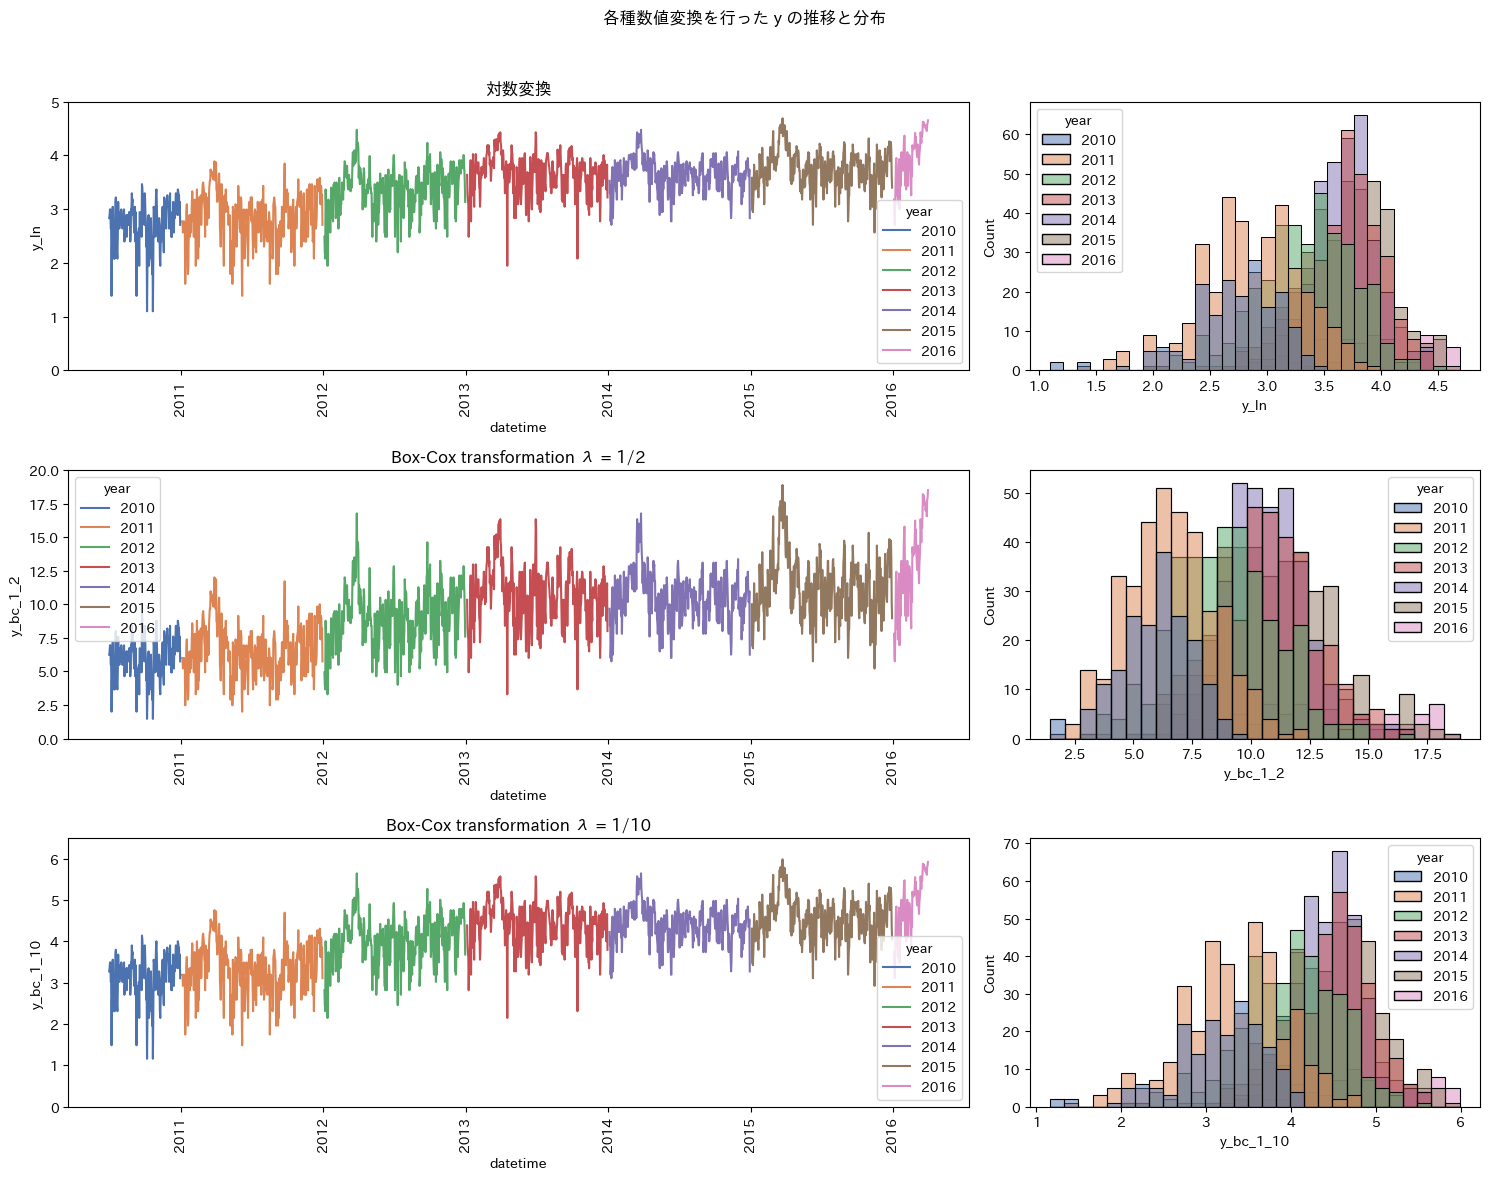

In [ ]:
# 数値変換して、yの分布の対称性を改善する。対数変換とbox-cox変換(λ=1/2, 1/10)を試す

train = (
    train
    .with_columns([
        pl.col("y").log().alias("y_ln"),
        ((pl.col("y").pow(1/2) - 1) / (1/2)).alias("y_bc_1_2"),
        ((pl.col("y").pow(1/10) - 1) / (1/10)).alias("y_bc_1_10"),
    ])
)

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    height_ratios=[1, 1, 1], width_ratios=[2, 1],
    figsize=(15, 12) 
)

g_time_ln = sns.lineplot(data = train, x="datetime", y="y_ln", hue="year",palette="deep", ax=axes[0, 0])
g_hist_ln = sns.histplot(data = train, x="y_ln", hue="year", palette="deep", ax=axes[0, 1])

g_time_bc_1_2 = sns.lineplot(data = train, x="datetime", y="y_bc_1_2", hue="year",palette="deep", ax=axes[1, 0])
g_hist_bc_1_2 = sns.histplot(data = train, x="y_bc_1_2", hue="year", palette="deep", ax=axes[1, 1])

g_time_bc_1_10 = sns.lineplot(data = train, x="datetime", y="y_bc_1_10", hue="year",palette="deep", ax=axes[2, 0])
g_hist_bc_1_10 = sns.histplot(data = train, x="y_bc_1_10", hue="year", palette="deep", ax=axes[2, 1])

# 調整
plt.setp(g_time_ln.get_xticklabels(), rotation = 90)
plt.setp(g_time_ln, ylim = (0, 5), title = "対数変換")
plt.setp(g_time_bc_1_2.get_xticklabels(), rotation = 90)
plt.setp(g_time_bc_1_2, ylim = (0, 20), title = "Box-Cox transformation λ = 1/2")
plt.setp(g_time_bc_1_10.get_xticklabels(), rotation = 90)
plt.setp(g_time_bc_1_10, ylim = (0, 6.5), title = "Box-Cox transformation λ = 1/10")

plt.suptitle("各種数値変換を行った y の推移と分布")
plt.tight_layout(rect = [0, 0, 1, 0.96])# 余白の調整  
plt.show()

グラフについてのコメント
- 目的変数を対称的な形に近づけて逆変換も簡単な自然対数変換が良さそう(ほんとに？)

# 参考サイト  
[コンペサイト アップル 引越し需要予測](https://signate.jp/competitions/269/data)  
[SIGNATE SOTA アップル 引越し需要予測 備忘録](https://zenn.dev/tremendous1192/articles/ea6e73359ee764)  
